In [15]:
# To import the data we need the dicom library
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

import importlib
from tqdm import tqdm
import pickle

from os.path import dirname, join
from pprint import pprint

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

import aux_preprocessing as aux

In [8]:
week1data = aux._getstudies("Thorax_Abdomen/week1/DICOMDIR")
week2data = aux._getstudies("Thorax_Abdomen/week2/DICOMDIR")
week3data = aux._getstudies("Thorax_Abdomen/week3/DICOMDIR")
week4data = aux._getstudies("Thorax_Abdomen/week4/DICOMDIR")
week5data = aux._getstudies("Thorax_Abdomen/week5/DICOMDIR")
week6data = aux._getstudies("Thorax_Abdomen/week6/DICOMDIR")
week7data = aux._getstudies("Thorax_Abdomen/week7/DICOMDIR")

In [10]:
week22data = aux._getstudies("Thorax_Abdomen/week2_2/DICOMDIR")
week23data = aux._getstudies("Thorax_Abdomen/week2_3/DICOMDIR")
week24data = aux._getstudies("Thorax_Abdomen/week2_4/DICOMDIR")
week25data = aux._getstudies("Thorax_Abdomen/week2_5/DICOMDIR")
week32data = aux._getstudies("Thorax_Abdomen/week3_2/DICOMDIR")
week33data = aux._getstudies("Thorax_Abdomen/week3_3/DICOMDIR")
week72data = aux._getstudies("Thorax_Abdomen/week7_2/DICOMDIR")

In [2]:
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

from os.path import dirname, join
from pprint import pprint

import pydicom
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir

# fetch the path to the test data
#filepath = get_testdata_files('DICOMDIR')[0]
#print('Path to the DICOM directory: {}'.format(filepath))
# load the data

def _getstudies(filepath):
    filepath = filepath 
    dicom_dir = read_dicomdir(filepath)
    base_dir = dirname(filepath)

    allstudies = {}

    # go through the patient record and print information
    for patient_record in dicom_dir.patient_records:
#         if (hasattr(patient_record, 'PatientID') and
#                 hasattr(patient_record, 'PatientName')):
#             print("Patient: {}: {}".format(patient_record.PatientID,
#                                            patient_record.PatientName))
        studies = patient_record.children
        # got through each serie
        for study in studies:
#             print(" " * 4 + "Study {}: {}: {}".format(study.StudyID,
#                                                       study.StudyDate,
#                                                       study.StudyDescription))
            allstudies[study.StudyID] = []
            all_series = study.children
            # go through each serie
            tmpseries = {}
            for series in all_series:
                image_count = len(series.children)
                plural = ('', 's')[image_count > 1]

                # Write basic series info and image count

                # Put N/A in if no Series Description
                if 'SeriesDescription' not in series:
                    series.SeriesDescription = "N/A"
#                 print(" " * 8 + "Series {}: {}: {} ({} image{})".format(
#                     series.SeriesNumber, series.Modality, series.SeriesDescription,
#                     image_count, plural))

                # Open and read something from each image, for demonstration
                # purposes. For simple quick overview of DICOMDIR, leave the
                # following out
#                 print(" " * 12 + "Reading images...")
                image_records = series.children
                image_filenames = [join(base_dir, *image_rec.ReferencedFileID)
                                   for image_rec in image_records]

                datasets = [pydicom.dcmread(image_filename)
                            for image_filename in image_filenames]

                patient_names = set(ds.PatientName for ds in datasets)
                patient_IDs = set(ds.PatientID for ds in datasets)

                # List the image filenames
#                 print("\n" + " " * 12 + "Image filenames:")
#                 print(" " * 12, end=' ')
                #pprint(image_filenames, indent=12)

                # Expect all images to have same patient name, id
                # Show the set of all names, IDs found (should each have one)
#                 print(" " * 12 + "Patient Names in images..: {}".format(
#                     patient_names))
#                 print(" " * 12 + "Patient IDs in images..: {}".format(
#                     patient_IDs))
                tmpseries[int(series.SeriesNumber)] = datasets

            allstudies[study.StudyID].append(tmpseries)
    return allstudies

# These are the dicom studies in the dicomdir
allstudies = _getstudies("Thorax_Abdomen/week1/DICOMDIR")

# Functions to determine size of a patient

In [38]:
def sizeSlice(s):
    ## determines the amount of pixels that are above the threshold for a slice
    threshold_mask = s.pixel_array > 800
    tmpmask = ndimage.binary_erosion(threshold_mask,iterations =6)
    closedmask = ndimage.binary_fill_holes(tmpmask)
    n_pixels = np.sum(closedmask)      ## # pixels above threshold
    v_pixel = s.PixelSpacing[0]*s.PixelSpacing[1]*s.SliceThickness *10**(-6) # volume 1 pixel in leters
    return n_pixels*v_pixel

def sizeSlice_wo_hollow(s):
    threshold_mask = s.pixel_array > 800
    tmpmask = ndimage.binary_erosion(threshold_mask,iterations =6)
    n_pixels = np.sum(tmpmask)      ## # pixels above threshold
    v_pixel = s.PixelSpacing[0]*s.PixelSpacing[1]*s.SliceThickness *10**(-6) # volume 1 pixel in leters
    return n_pixels*v_pixel

def sizePatient(patient):
    ## gives volume of scanned body in liters
    volume = 0
    for s in patient:
        volume += sizeSlice(s)
    return volume



Looking at the two patients below, we see that the first person has a volume of 32 dm^3 and the second is a fat lady of 51 dm^3 (only abdomen!), we can see a lot more fat around her belly ;)

In [40]:

plt.imshow(allstudies['E864M5E16Q'][0][1][80].pixel_array)
sizePatient(allstudies['E864M5E16Q'][0][1])


NameError: name 'allstudies' is not defined

51.512629688415515

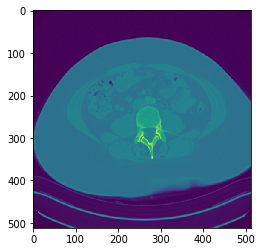

In [15]:
plt.imshow(allstudies['E864M5E17Q'][0][7][80].pixel_array)
sizePatient(allstudies['E864M5E17Q'][0][7])

# Effect size on dosis

In [16]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [39]:
basedir = "Thorax_Abdomen/"
ctdatadir = os.listdir(basedir)

overview = {}



for tmpdata in tqdm(ctdatadir):
    weekstudies = _getstudies(os.path.join(basedir,tmpdata,"DICOMDIR"))
    for key in weekstudies.keys():
        tmpstudy = weekstudies[key][0]
        if len(tmpstudy.keys()) > 1:
            print ("More than 1 study for this patient!")
            break
            
        seriesid = list(tmpstudy.keys())
#         print(seriesid)
        seriesid = seriesid[0]
        i = 0
        overview[key] = {}
        for s in tmpstudy[seriesid]:
            overview[key][i] = {}
            overview[key][i]['dose'] = s.CTDIvol
            overview[key][i]['size'] = sizeSlice(s)
            overview[key][i]['size_wo_hollow'] = sizeSlice_wo_hollow(s)
            i +=1

        



  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

  7%|█████▉                                                                             | 1/14 [01:16<16:32, 76.37s/it]

 14%|███████████▊                                                                       | 2/14 [01:50<12:44, 63.68s/it]

 21%|█████████████████▊                                                                 | 3/14 [01:57<08:33, 46.66s/it]

 29%|███████████████████████▋                                                           | 4/14 [02:04<05:46, 34.66s/it]

 36%|█████████████████████████████▋                                                     | 5/14 [02:25<04:34, 30.55s/it]

 43%|███████████████████████████████████▌                                               | 6/14 [02:43<03:36, 27.02s/it]

 50%|█████████████████████████████████████████▌                                         | 7/14 [03:19<03:27, 29.65s/it]

 57%|█████████████████████████

In the above code we load all the dose values and sizes of each patient.

In [40]:
size = []
size_h = []
dose = []

for key in iter(overview):
    for s in iter(doseoverview[key]):
        dose.append(overview[key][s]['dose'])
        size.append(overview[key][s]['size'])
        size_h.append(overview[key][s]['size_wo_hollow'])

size = np.array(size).reshape(-1, 1)
dose = np.array(dose).reshape(-1, 1)

In [1]:
reg = LinearRegression().fit(size, dose)
# reg2 = LinearRegression().fit(size_h, dose)

pred_dose = reg.predict(size)
plt.plot(size,dose,  'o', mfc='none')
plt.plot(size,pred_dose)
plt.xlabel('size (dm^3)')
plt.ylabel('dose')
plt.show()



print(reg.coef_,reg.intercept_)

NameError: name 'LinearRegression' is not defined

#  Save results

save results in a list containting al the values for the different size features, obtained from the pictures

In [52]:
### Create pickle file containing size features
relev_feats = ['Size',               ## Size of the body, using the filled in pictrure
               'Size_hollow',        ## Size of the body without the hollow parts
               'Im_mean',
              ]            ## Mean value of the pixels in the images


importlib.reload(aux)
x = []

week = 1    
weekname = 'week'+str(week)+'data'
weekdata = eval(weekname)
slicce = week1data['E864M5E16Q'][0][1][0]
for feat in relev_feats:
    x = x+aux.get_feature_value(slicce,feat)
    picture = slicce.pixel_array
    
p = len(x)
print(p)
print(x)

3
[0.18768908660888672, 0.18244256904602052, 415.0517883300781]


In [45]:
### Create pickle file containing size features

importlib.reload(aux)

X = np.empty((0,p))


for week in tqdm([1,2,22,23,24,25,3,32,33,4,5,6,7,72]):
    Yi = np.empty((0,1))
    Xi = np.empty((0,p))
    weekname = 'week'+str(week)+'data'
    weekdata = eval(weekname)
    for scan in list(weekdata.keys()):
        for series in list(weekdata[scan][0].keys()):
            for slicce in weekdata[scan][0][series]:
                x = []
                for feat in relev_feats:
                    x = x+aux.get_feature_value(slicce,feat)
                Xi = np.append(Xi,[np.array(x)],axis=0)
    X = np.append(X,Xi,axis=0)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [04:08<00:00, 19.11s/it]


In [47]:
## save the data
with open('data/X_sizes.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X], f)
    

In [48]:
X

array([[1.87689087e-01, 1.82442569e-01, 4.15051788e+02],
       [1.93475792e-01, 1.88929607e-01, 4.23391655e+02],
       [1.98927868e-01, 1.88104984e-01, 4.32225895e+02],
       ...,
       [2.67145583e-01, 2.67145583e-01, 4.83718376e+02],
       [2.64878591e-01, 2.64632288e-01, 4.76173985e+02],
       [2.61852585e-01, 2.61852585e-01, 4.69840424e+02]])

So the size has a positive correlation with the dosis used. The regression line is described by $$dose = reg.coef_ \cdot size(dm^3)+ reg.intercept_$$

TODO
- Add function to python file
- Add size without hollow parts,
- Size off differnt organs (bones, fat, etc.)
- function per slice


- image quality, high gradients, maybe gradient at boundary of the body

